# Análisis y predicción de flujos de movilidad vacacional en España Peninsula-Islas

## 0. Installs and Imports

In [1]:
# Installs
#%pip install -q -U matplotlib numpy pandas scikit-learn seaborn
#%pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data

In [3]:
path_2022 = "../data/movilidad_provincias_2022.csv"
path_2023 = "../data/movilidad_provincias_2023.csv"
path_2024 = "../data/movilidad_provincias_2024.csv"

original_data_2022 = pd.read_csv(path_2022, sep=",")
original_data_2023 = pd.read_csv(path_2023, sep=",")
original_data_2024 = pd.read_csv(path_2024, sep=",")

df_2022 = original_data_2022.copy()
df_2023 = original_data_2023.copy()
df_2024 = original_data_2024.copy()

df = pd.concat([df_2022, df_2023, df_2024])

# Holidays dataset
path_festivos_2022 = "../data/bank_holidays_22.csv"
path_festivos_2023_24 = "../data/bank_holidays_2324.csv"

festivos_2022 = pd.read_csv(path_festivos_2022, sep=";", encoding='ISO-8859-1')
festivos_2023_24 = pd.read_csv(path_festivos_2023_24, sep=";", encoding='ISO-8859-1')
festivos = pd.concat([festivos_2022, festivos_2023_24])

In [4]:
""" df_2022.info()
df_2022.head() """

' df_2022.info()\ndf_2022.head() '

## 2. Data Preparation

### 2.1 Dataset Exploratory Data Analysis (EDA)

### 2.2 Data Preparation

In [5]:
# Juntar los datasets de movilidad con los de festivos
# 1. Hacer el merge inicial
merged_df = pd.merge(df, festivos, left_on=['day', 'provincia_destino_name'], right_on=['holiday_date', 'desc_provincia'], how='left')

# 2. Crear columnas dummy y renombrarlas
merged_df = pd.get_dummies(merged_df, columns=['holiday_type'])
merged_df = merged_df.rename(columns={
    'holiday_type_Nacional': 'national_holiday_destino', 
    'holiday_type_Autonómico': 'regional_holiday_destino'
})

# 3. Convertir a int manteniendo todas las columnas
merged_df['national_holiday_destino'] = merged_df['national_holiday_destino'].fillna(0).astype(int)
merged_df['regional_holiday_destino'] = merged_df['regional_holiday_destino'].fillna(0).astype(int)

# 4. Ver resultados con festivos
merged_df_holidays = merged_df[merged_df['holiday_date'].notnull()]
#merged_df_holidays

In [6]:
# Añadir columnas de Verano, Navidad, Semana Santa
fechas_verano = (
    pd.concat([
        # Verano 2023
        pd.Series(pd.date_range(start='2023-07-01', end='2023-08-31')),
        # Verano 2024
        pd.Series(pd.date_range(start='2024-07-01', end='2024-08-31'))
    ])
    .dt.strftime('%Y-%m-%d')
    .tolist()
)
fechas_navidad = (
    pd.concat([
        # Navidad 2022-2023
        pd.Series(pd.date_range(start='2022-12-22', end='2023-01-08')),
        # Navidad 2023-2024
        pd.Series(pd.date_range(start='2023-12-22', end='2024-01-07'))
    ])
    .dt.strftime('%Y-%m-%d')
    .tolist()
)
fechas_semana_santa = (
    pd.concat([
        # Semana santa 2023
        pd.Series(pd.date_range(start='2023-04-02', end='2023-04-09')),
        # Semana santa 2024
        pd.Series(pd.date_range(start='2024-03-24', end='2024-03-31'))
    ])
    .dt.strftime('%Y-%m-%d')
    .tolist()
)

# Crear una columna en el dataset que indique si es verano o no
merged_df['es_verano'] = merged_df['day'].isin(fechas_verano)
merged_df['es_verano'] = merged_df['es_verano'].astype(int)
# Crear una columna en el dataset que indique si es navidad o no
merged_df['es_navidad'] = merged_df['day'].isin(fechas_navidad)
merged_df['es_navidad'] = merged_df['es_navidad'].astype(int)
# Crear una columna en el dataset que indique si es semana santa o no
merged_df['es_semana_santa'] = merged_df['day'].isin(fechas_semana_santa)
merged_df['es_semana_santa'] = merged_df['es_semana_santa'].astype(int)

In [7]:
# DATA CLEANING
cleaned_df = merged_df.copy()
# Eliminar columnas que no se van a usar
cleaned_df = cleaned_df.drop(columns=[
    'provincia_origen', 'provincia_destino', 'cod_provincia', 'desc_provincia', 'ine_auto_name', 'holiday_date', 'holiday_desc'
])
#cleaned_df

In [8]:
# DATA FILTERING
df = cleaned_df.copy()
# Keep only the rows with destination province = ['Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife']
insular_provinces = ['Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife']
df = df[df['provincia_destino_name'].isin(insular_provinces)]
#df

## 3. Feature extraction

In [9]:
features_df = df.copy()

# Add two new columns, day_of_week and month
features_df['date'] = pd.to_datetime(features_df['day'])
features_df['day_of_week'] = features_df['date'].dt.day_name()
features_df['month'] = features_df['date'].dt.month
features_df['year'] = features_df['date'].dt.year
features_df.drop(columns=['day'], inplace=True)

#features_df

In [10]:
# Sum all the trips to the same destination province
total_llegadas_islas = features_df.groupby([
    'date', 'provincia_destino_name', 'day_of_week', 'month', 'year', 
    'national_holiday_destino', 'regional_holiday_destino', 'es_verano', 'es_navidad', 'es_semana_santa'
])['viajes'].sum().reset_index()
total_llegadas_islas

,date,provincia_destino_name,day_of_week,month,year,national_holiday_destino,regional_holiday_destino,es_verano,es_navidad,es_semana_santa,viajes
0,2022-09-01,"Balears, Illes",Thursday,9,2022,0,0,0,0,0,27489
1,2022-09-01,"Palmas, Las",Thursday,9,2022,0,0,0,0,0,17094
2,2022-09-01,Santa Cruz de Tenerife,Thursday,9,2022,0,0,0,0,0,14233
3,2022-09-02,"Balears, Illes",Friday,9,2022,0,0,0,0,0,29444
4,2022-09-02,"Palmas, Las",Friday,9,2022,0,0,0,0,0,16292
...,...,...,...,...,...,...,...,...,...,...,...
2275,2024-09-29,"Palmas, Las",Sunday,9,2024,0,0,0,0,0,18728
2276,2024-09-29,Santa Cruz de Tenerife,Sunday,9,2024,0,0,0,0,0,17824
2277,2024-09-30,"Balears, Illes",Monday,9,2024,0,0,0,0,0,26655
2278,2024-09-30,"Palmas, Las",Monday,9,2024,0,0,0,0,0,19614


In [11]:
# Aparear dia de la semana i mes
total_llegadas_islas['day_of_week_month'] = total_llegadas_islas['day_of_week'] + '_' + total_llegadas_islas['month'].astype(str)
#total_llegadas_islas

## 4. Model

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df1 = total_llegadas_islas.copy()
df1.drop(columns=['date'], inplace=True)
df1.drop(columns=['year'], inplace=True)

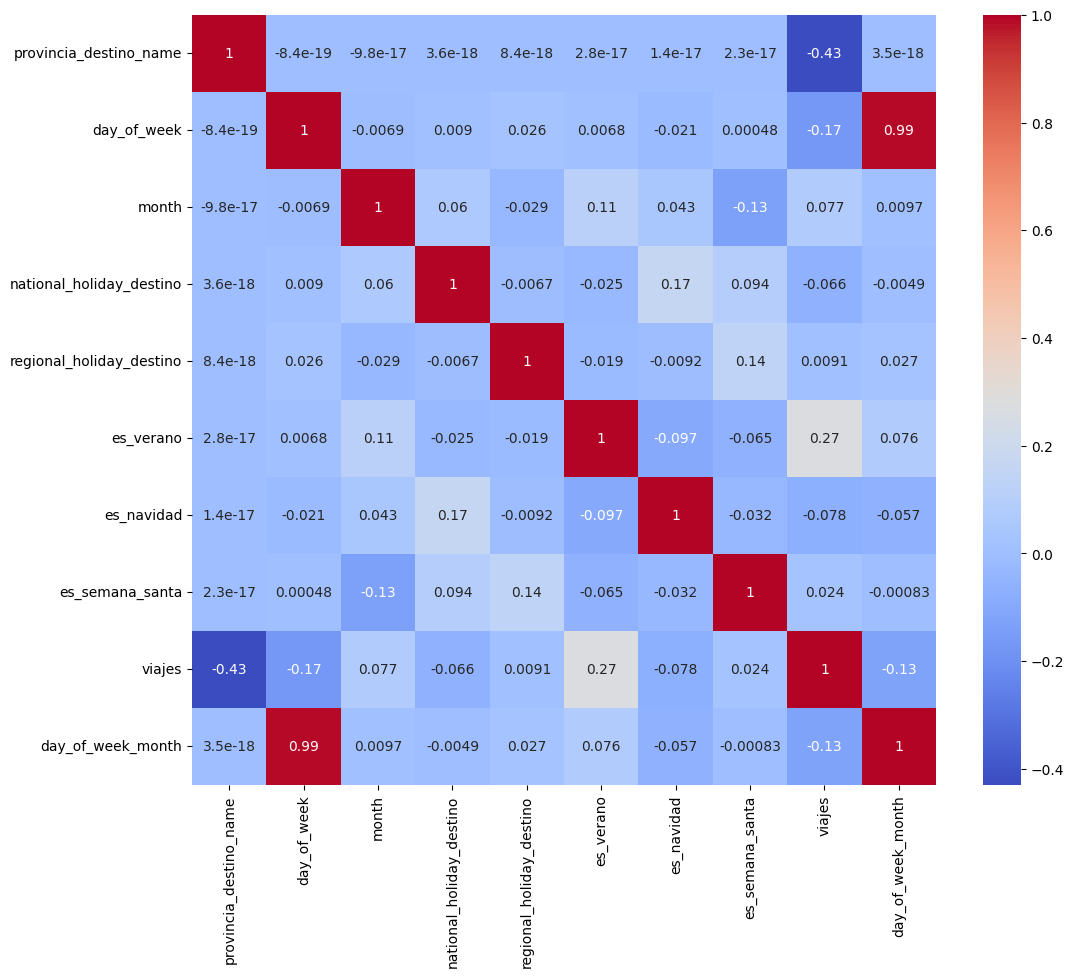

In [13]:
# Label encoding
le_day_of_week = LabelEncoder()
df1['day_of_week'] = le_day_of_week.fit_transform(df1['day_of_week'])
le_provincia_destino_name = LabelEncoder()
df1['provincia_destino_name'] = le_provincia_destino_name.fit_transform(df1['provincia_destino_name'])
le_day_of_week_month = LabelEncoder()
df1['day_of_week_month'] = le_day_of_week_month.fit_transform(df1['day_of_week_month'])

df1

# Correlation matrix
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm')
plt.show()

In [14]:
features = df1.drop(columns=['viajes']) # 'day_of_week_month'
target = df1['viajes']

X = features
y = target

In [15]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(1710, 570, 1710, 570)

In [16]:
# RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [17]:
# GRADIENT BOOSTING REGRESSOR
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

In [18]:
# XGBOOST REGRESSOR (https://xgboost.readthedocs.io/en/stable/index.html)
import xgboost as xgbst
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [19]:
# LIGHT GBM REGRESSOR (https://lightgbm.readthedocs.io/en/latest/index.html)
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
import lightgbm as lgbmr
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 1710, number of used features: 8
[LightGBM] [Info] Start training from score 19183.076023


In [20]:
# Grid Search with different hyperparameters to find the best ones for each model
from sklearn.model_selection import GridSearchCV

# Linear Regression (TODO: Tocar els paràmetres)
""" lr_params = {'fit_intercept': [True, False], 'normalize': [True, False]}
lr_gs = GridSearchCV(lr, lr_params, cv=5)
lr_gs.fit(X_train, y_train)
lr_best = lr_gs.best_estimator_ """

# Gradient Boosting Regressor (TODO: Tocar els paràmetres)
#gbr_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
#gbr_gs = GridSearchCV(gbr, gbr_params, cv=5)
#gbr_gs.fit(X_train, y_train)
#gbr_best = gbr_gs.best_estimator_

# Random Forest Regressor (TODO: Tocar els paràmetres)
#rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
#rf_gs = GridSearchCV(rf, rf_params, cv=5)
#rf_gs.fit(X_train, y_train)
#rf_best = rf_gs.best_estimator_

# XGBoost Regressor (TODO: Mirar quins parametres té)
""" xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
xgb_gs = GridSearchCV(xgb, xgb_params, cv=5)
xgb_gs.fit(X_train, y_train)
xgb_best = xgb_gs.best_estimator_ """

" xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}\nxgb_gs = GridSearchCV(xgb, xgb_params, cv=5)\nxgb_gs.fit(X_train, y_train)\nxgb_best = xgb_gs.best_estimator_ "

### 4.2 Tuning

In [21]:
# Tuning all models
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def tuning_and_evaluating_models(X_train, y_train, X_test, y_test, models_with_params):
    results = {}

    for model, params in models_with_params.items():
        print(f"\n----------------------\nOptimizando {model.__class__.__name__} con GridSearchCV\n")

        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        # Mejor modelo
        best_model = grid_search.best_estimator_
        print(f"Mejores hiperparámetros para {model.__class__.__name__}: {grid_search.best_params_}")

        # Predicciones y métricas
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Guardar resultados
        results[model.__class__.__name__] = {
            'Best Params': grid_search.best_params_,
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        }

        # Mostrar resultados
        print(f"\nResultados de {model.__class__.__name__}:")
        print(f"MSE = {mse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")

    print("\n----------------------\nEvaluación completa\n")
    return results

In [22]:
models_with_params = {
    GradientBoostingRegressor(): {
        'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 1],
        'n_estimators': [10, 50, 100, 200, 300, 500],
        'max_depth': [3, 5, 8, 10, 12, 15, 20, 25]
    },
    XGBRegressor(): {
        'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 1],
        'n_estimators': [10, 50, 100, 200, 300, 500],
        'max_depth': [3, 5, 8, 10, 12, 15, 20, 25]
    },
    LGBMRegressor(): {
        'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 1],
        'n_estimators': [10, 50, 100, 200, 300, 500],
        'num_leaves': [15, 30, 50, 75, 100, 150, 200]
    }
}

results = tuning_and_evaluating_models(X_train, y_train, X_test, y_test, models_with_params)


----------------------
Optimizando GradientBoostingRegressor con GridSearchCV

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Mejores hiperparámetros para GradientBoostingRegressor: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}

Resultados de GradientBoostingRegressor:
MSE = 8911655.9368, MAE = 2286.3481, R2 = 0.6883

----------------------
Optimizando XGBRegressor con GridSearchCV

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Mejores hiperparámetros para XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Resultados de XGBRegressor:
MSE = 8777123.4259, MAE = 2264.8127, R2 = 0.6930

----------------------
Optimizando LGBMRegressor con GridSearchCV

Fitting 5 folds for each of 294 candidates, totalling 1470 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

## 5. Evaluation and Conclusions

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("----------------------")
print(f"Random Forest Regressor: MSE = {mse_rf}, MAE = {mae_rf}, R2 = {r2_rf}")
print(f"Gradient Boosting Regressor: MSE = {mse_gbr}, MAE = {mae_gbr}, R2 = {r2_gbr}")
print(f"XGBoost: MSE = {mse_xgb}, MAE = {mae_xgb}, R2 = {r2_xgb}")
print(f"Light GBM: MSE = {mse_lgbm}, MAE = {mae_lgbm}, R2 = {r2_lgbm}")
print("----------------------")

----------------------
Random Forest Regressor: MSE = 10020677.084092846, MAE = 2412.4853053262573, R2 = 0.6495464680131706
Gradient Boosting Regressor: MSE = 8993330.189223956, MAE = 2290.6767777255823, R2 = 0.6854759111896241
XGBoost: MSE = 10065019.64812864, MAE = 2402.4528268914473, R2 = 0.6479956737850675
Light GBM: MSE = 9194197.847213967, MAE = 2315.629122914861, R2 = 0.6784509587224632
----------------------


In [24]:
# -- (MAE) Error medio total para dar un +- de las predicciones --   (Gradient Boosting Regressor)
mean_error = np.mean(np.abs(y_test - y_pred_gbr))
print(f"Mean Absolute Error: {mean_error}")

errors = []
for i in range(len(y_test)):
    #print(f"Real value: {y_test.iloc[i]}, Predicted value: {y_pred_gbr[i]}")
    error = np.abs(y_test.iloc[i] - y_pred_gbr[i])
    errors.append(error)
mean_error = sum(errors) / len(errors)
print(f"Mean Absolute Error: {mean_error}")

# % of error
total = sum(y_test)
error = sum(errors)
error_percentage = (error / total) * 100
print(f"Error percentage: {error_percentage}%")


Mean Absolute Error: 2290.6767777255823
Mean Absolute Error: 2290.67677772558
Error percentage: 11.837593761878006%


In [25]:
# Calcular el error de cada predicción, no el general

In [26]:
# Objetivos: 
## Bajar el error medio total a menos del 5% (o 10%)
## Bajar el error por muestra al 20%

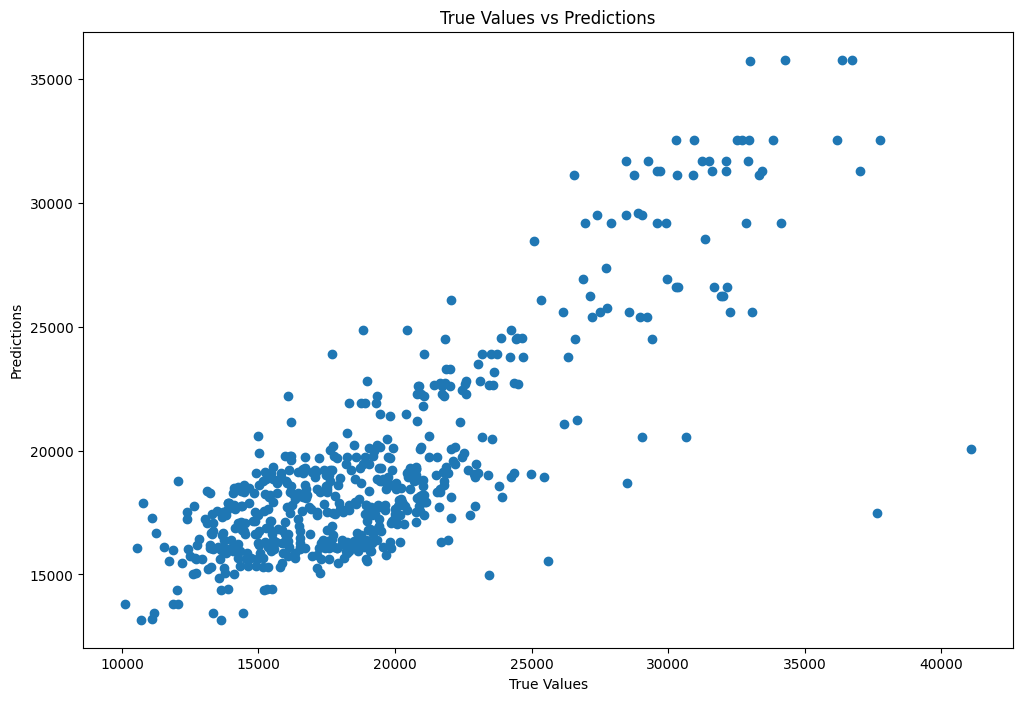

In [27]:
# Scatter plot del modelo Gradient Boosting Regressor
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_gbr)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [28]:
# Feature importances

""" feature_importances_lr = lr.coef_
feature_importances_gbr = gbr.feature_importances_
feature_importances_rf = rf.feature_importances_
xgbst.plot_importance(xgb)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Linear Regression': feature_importances_lr,
    'Gradient Boosting': feature_importances_gbr,
    'Random Forest': feature_importances_rf
})

print(feature_importances) """

" feature_importances_lr = lr.coef_\nfeature_importances_gbr = gbr.feature_importances_\nfeature_importances_rf = rf.feature_importances_\nxgbst.plot_importance(xgb)\n\nfeature_importances = pd.DataFrame({\n    'Feature': X.columns,\n    'Linear Regression': feature_importances_lr,\n    'Gradient Boosting': feature_importances_gbr,\n    'Random Forest': feature_importances_rf\n})\n\nprint(feature_importances) "

In [29]:
# EXPLAINABILITY OF THE MODEL (ELI5, LIME, SHAP) ...

In [30]:
# For classifier: Precision, recall, f1-score, accuracy, confusion matrix, DENSITY CHARTS, ...
# For regressor: R2, RMSE, MAE, ...


In [31]:
# Confusion matrices
""" from sklearn.metrics import confusion_matrix

confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)
confusion_matrix_gbr = confusion_matrix(y_test, y_pred_gbr)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.heatmap(confusion_matrix_lr, annot=True, cmap='coolwarm', ax=ax[0])
sns.heatmap(confusion_matrix_gbr, annot=True, cmap='coolwarm', ax=ax[1])
sns.heatmap(confusion_matrix_rf, annot=True, cmap='coolwarm', ax=ax[2])
sns.heatmap(confusion_matrix_xgb, annot=True, cmap='coolwarm', ax=ax[3])
ax[0].set_title("Linear Regression")
ax[1].set_title("Gradient Boosting Regressor")
ax[2].set_title("Random Forest")
ax[3].set_title("XGBoost")
plt.show() """

' from sklearn.metrics import confusion_matrix\n\nconfusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)\nconfusion_matrix_gbr = confusion_matrix(y_test, y_pred_gbr)\nconfusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)\nconfusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)\n\nfig, ax = plt.subplots(1, 4, figsize=(20, 5))\nsns.heatmap(confusion_matrix_lr, annot=True, cmap=\'coolwarm\', ax=ax[0])\nsns.heatmap(confusion_matrix_gbr, annot=True, cmap=\'coolwarm\', ax=ax[1])\nsns.heatmap(confusion_matrix_rf, annot=True, cmap=\'coolwarm\', ax=ax[2])\nsns.heatmap(confusion_matrix_xgb, annot=True, cmap=\'coolwarm\', ax=ax[3])\nax[0].set_title("Linear Regression")\nax[1].set_title("Gradient Boosting Regressor")\nax[2].set_title("Random Forest")\nax[3].set_title("XGBoost")\nplt.show() '